Imports

In [1]:
import numpy as np
import torch
import torchvision
import torch.nn as nn
import matplotlib.pyplot as plt
import torch_fidelity

Utility Functions

In [15]:
from helper_data import get_dataloaders_celeba
from helper_train import train_gan_v1
from helper_utils import set_deterministic, set_all_seeds
from helper_plotting import plot_multiple_training_losses
from helper_generate import generate_imgs

In [4]:
CUDA_DEVICE_NUM = 0
DEVICE = torch.device(f'cuda:{CUDA_DEVICE_NUM}' if torch.cuda.is_available() else 'cpu')

RANDOM_SEED = 42
GENERATOR_LEARNING_RATE = 0.0002
DISCRIMINATOR_LEARNING_RATE = 0.0002

NUM_EPOCHS = 20
BATCH_SIZE = 128

IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS = 64, 64, 3

In [5]:
set_deterministic
set_all_seeds(RANDOM_SEED)

In [6]:
custom_transforms = torchvision.transforms.Compose([
    torchvision.transforms.CenterCrop((160,160)),
    torchvision.transforms.Resize([IMAGE_HEIGHT, IMAGE_WIDTH]),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
])

train_loader, valid_loader, test_loader = get_dataloaders_celeba(batch_size = BATCH_SIZE,
                                                                train_transforms = custom_transforms,
                                                                test_transforms = custom_transforms,
                                                                num_workers = 4)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


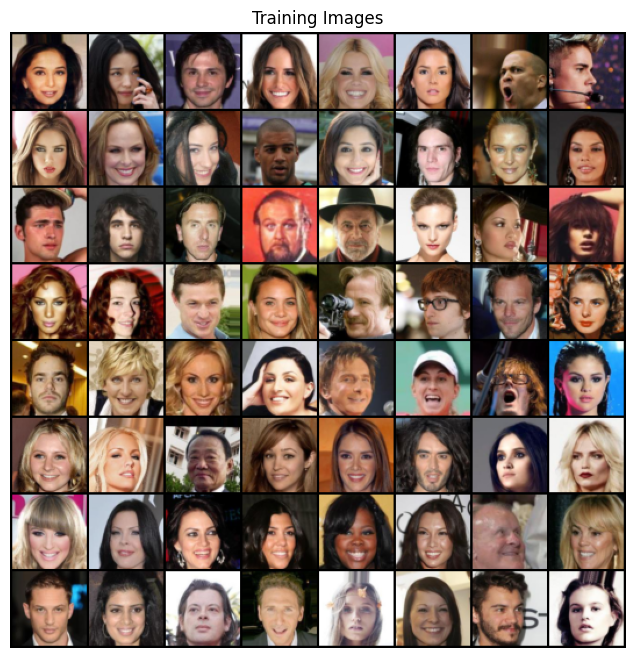

In [7]:
for images, labels in train_loader:  
    break
plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(torchvision.utils.make_grid(images[:64], 
                                                    nrow=8,
                                                    padding=2,
                                                    normalize=True),
                        (1, 2, 0)))
plt.savefig('./results/train_imgs.jpg')
plt.show()

In [8]:
class DCGAN(torch.nn.Module):

    def __init__( self, latent_dim=100, 
                  num_feat_maps_gen=64, num_feat_maps_dis=64,
                  color_channels=3 ):
        super().__init__()
        
        
        self.generator = nn.Sequential(
             
            #num of filters : 512
            #filter size : 4x4
             nn.ConvTranspose2d( latent_dim, num_feat_maps_gen*8, 
                                kernel_size=4, stride=1, padding=0,
                                bias=False ),
             nn.BatchNorm2d(num_feat_maps_gen*8),
             nn.LeakyReLU(inplace=True),
            
            #
            # size if latent_dim=100: num_feat_maps_gen*8 x 4 x 4
            #
            
            nn.ConvTranspose2d(num_feat_maps_gen*8, num_feat_maps_gen*4, 
                               kernel_size=4, stride=2, padding=1,
                               bias=False),
            nn.BatchNorm2d(num_feat_maps_gen*4),
            nn.LeakyReLU(inplace=True),
            #
            # size if latent_dim=100: num_feat_maps_gen*4 x 8 x 8
            #
            nn.ConvTranspose2d(num_feat_maps_gen*4, num_feat_maps_gen*2, 
                               kernel_size=4, stride=2, padding=1,
                               bias=False),
            nn.BatchNorm2d(num_feat_maps_gen*2),
            nn.LeakyReLU(inplace=True),
            #
            # size if latent_dim=100: num_feat_maps_gen*2 x 16 x 16
            #
            nn.ConvTranspose2d(num_feat_maps_gen*2, num_feat_maps_gen, 
                               kernel_size=4, stride=2, padding=1,
                               bias=False),
            nn.BatchNorm2d(num_feat_maps_gen),
            nn.LeakyReLU(inplace=True),
            #
            # size if latent_dim=100: num_feat_maps_gen x 32 x 32
            #
            nn.ConvTranspose2d(num_feat_maps_gen, color_channels, 
                               kernel_size=4, stride=2, padding=1,
                               bias=False),
            #
            # size: color_channels x 64 x 64
            #  
            nn.Tanh() #output between -1 to 1
        )
        
        self.discriminator = nn.Sequential(
            #
            # input size color_channels x image_height x image_width
            #
            nn.Conv2d(color_channels, num_feat_maps_dis,
                      kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(inplace=True),
            #
            # size: num_feat_maps_dis x 32 x 32
            #              
            nn.Conv2d(num_feat_maps_dis, num_feat_maps_dis*2,
                      kernel_size=4, stride=2, padding=1,
                      bias=False),        
            nn.BatchNorm2d(num_feat_maps_dis*2),
            nn.LeakyReLU(inplace=True),
            #
            # size: num_feat_maps_dis*2 x 16 x 16
            #   
            nn.Conv2d(num_feat_maps_dis*2, num_feat_maps_dis*4,
                      kernel_size=4, stride=2, padding=1,
                      bias=False),        
            nn.BatchNorm2d(num_feat_maps_dis*4),
            nn.LeakyReLU(inplace=True),
            #
            # size: num_feat_maps_dis*4 x 8 x 8
            #   
            nn.Conv2d(num_feat_maps_dis*4, num_feat_maps_dis*8,
                      kernel_size=4, stride=2, padding=1,
                      bias=False),        
            nn.BatchNorm2d(num_feat_maps_dis*8),
            nn.LeakyReLU(inplace=True),
            #
            # size: num_feat_maps_dis*8 x 4 x 4
            #   
            nn.Conv2d(num_feat_maps_dis*8, 1,
                      kernel_size=4, stride=1, padding=0),
            
            # size: 1 x 1 x 1
            nn.Flatten(),
            
        )

            
    def generator_forward(self, z):
        img = self.generator(z)
        return img
    
    def discriminator_forward(self, img):
        logits = model.discriminator(img)
        return logits

In [9]:
set_all_seeds(RANDOM_SEED)

model = DCGAN()
model.to(DEVICE)


optim_gen = torch.optim.Adam(model.generator.parameters(),
                             betas=(0.5, 0.999),
                             lr=GENERATOR_LEARNING_RATE)

optim_discr = torch.optim.Adam(model.discriminator.parameters(),
                               betas=(0.5, 0.999),
                               lr=DISCRIMINATOR_LEARNING_RATE)

In [10]:
log_dict = train_gan_v1(num_epochs=NUM_EPOCHS, model=model, 
                        optimizer_gen=optim_gen,
                        optimizer_discr=optim_discr,
                        latent_dim=100,
                        device=DEVICE, 
                        train_loader=train_loader,
                        logging_interval=100,
                        save_model='./dcgan_celeba.pt')

Epoch: 001/020 | Batch 000/1272 | Gen/Dis Loss: 2.2881/0.7329
Epoch: 001/020 | Batch 100/1272 | Gen/Dis Loss: 7.7528/0.3019
Epoch: 001/020 | Batch 200/1272 | Gen/Dis Loss: 3.4771/0.2056
Epoch: 001/020 | Batch 300/1272 | Gen/Dis Loss: 2.7286/0.1970
Epoch: 001/020 | Batch 400/1272 | Gen/Dis Loss: 2.5140/0.3384
Epoch: 001/020 | Batch 500/1272 | Gen/Dis Loss: 3.8605/0.1560
Epoch: 001/020 | Batch 600/1272 | Gen/Dis Loss: 4.1333/0.1892
Epoch: 001/020 | Batch 700/1272 | Gen/Dis Loss: 4.5413/0.2126
Epoch: 001/020 | Batch 800/1272 | Gen/Dis Loss: 3.9187/0.3571
Epoch: 001/020 | Batch 900/1272 | Gen/Dis Loss: 6.3469/0.4162
Epoch: 001/020 | Batch 1000/1272 | Gen/Dis Loss: 3.0842/0.2880
Epoch: 001/020 | Batch 1100/1272 | Gen/Dis Loss: 2.7166/0.1952
Epoch: 001/020 | Batch 1200/1272 | Gen/Dis Loss: 3.9303/0.2592
Time elapsed: 4.33 min
Epoch: 002/020 | Batch 000/1272 | Gen/Dis Loss: 5.3666/0.3710
Epoch: 002/020 | Batch 100/1272 | Gen/Dis Loss: 3.8093/0.1986
Epoch: 002/020 | Batch 200/1272 | Gen/Dis Lo

Visual Inspection

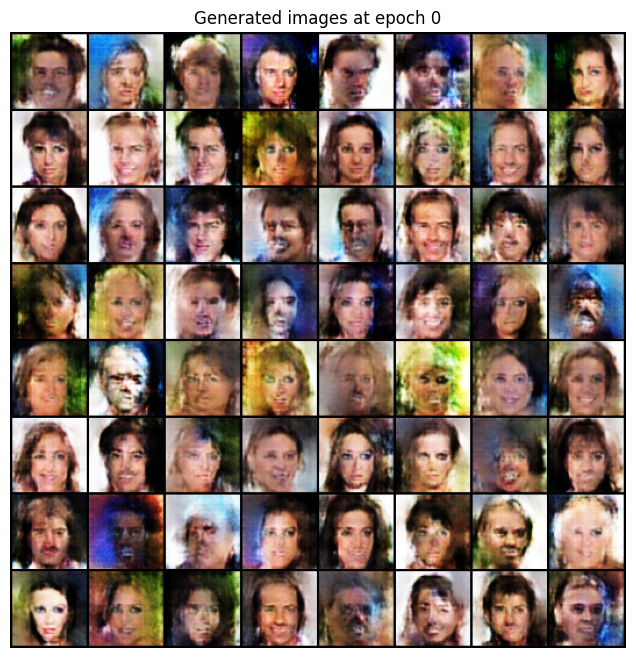

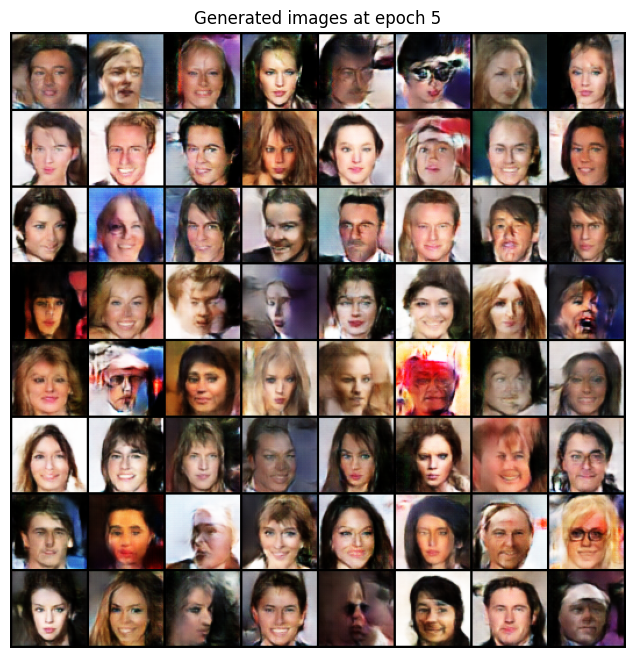

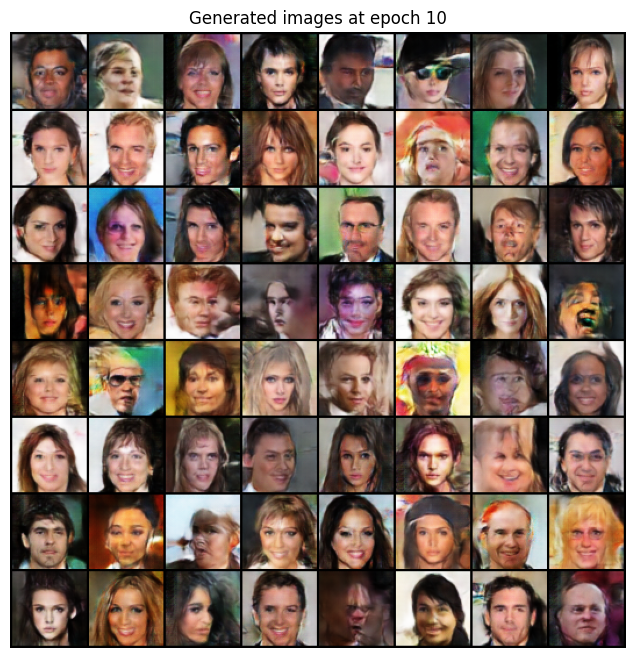

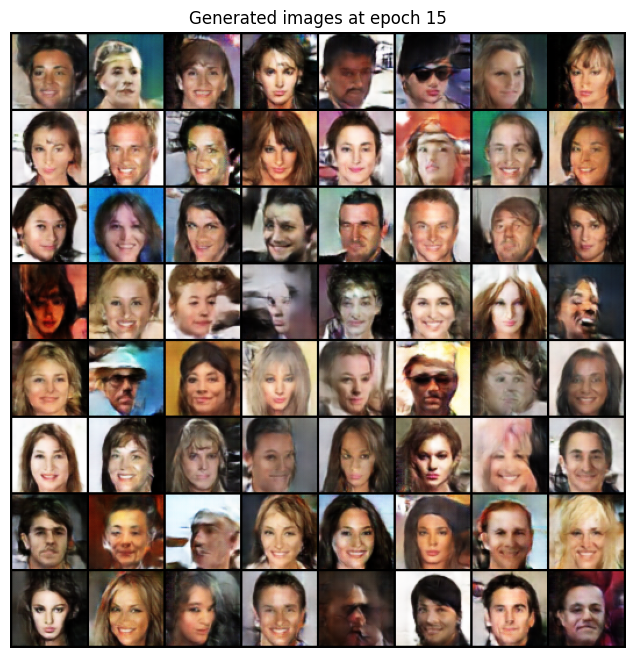

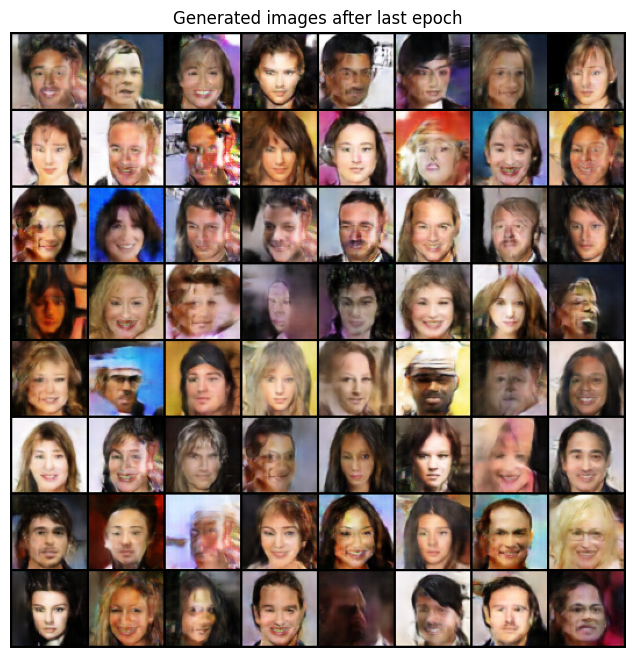

In [11]:
for i in range(0, NUM_EPOCHS, 5):
    
    plt.figure(figsize=(8, 8))
    plt.axis('off')
    plt.title(f'Generated images at epoch {i}')
    plt.imshow(np.transpose(log_dict['images_from_noise_per_epoch'][i], (1, 2, 0)))
    plt.show()
    
    
plt.figure(figsize=(8, 8))
plt.axis('off')
plt.title(f'Generated images after last epoch')
plt.imshow(np.transpose(log_dict['images_from_noise_per_epoch'][-1], (1, 2, 0)))
plt.show()

Generate Images

In [32]:
generate_imgs('dcgan_celeba.pt', DCGAN, num_imgs=500, batch_size=128, save=True)

Fréchet Inception Distance (FID)

In [36]:
real_images_dir = './results/real_imgs'
generated_images_dir = './results/generated_imgs'

fid_value = torch_fidelity.calculate_metrics(input1=real_images_dir, input2=generated_images_dir, fid=True)
print(f"FID: {fid_value['frechet_inception_distance']}")

Creating feature extractor "inception-v3-compat" with features ['2048']
Downloading: "https://github.com/toshas/torch-fidelity/releases/download/v0.2.0/weights-inception-2015-12-05-6726825d.pth" to C:\Users\sathw/.cache\torch\hub\checkpoints\weights-inception-2015-12-05-6726825d.pth
100%|██████████| 91.2M/91.2M [00:04<00:00, 19.4MB/s]
Extracting statistics from input 1


ValueError: Input descriptor "input" field can be either an instance of Dataset, GenerativeModelBase class, or a string, such as a path to a name of a registered dataset (cifar10-train, cifar10-val, stl10-train, stl10-test, stl10-unlabeled), a directory with file samples, or a path to an ONNX or PTH (JIT) module

Training Loss

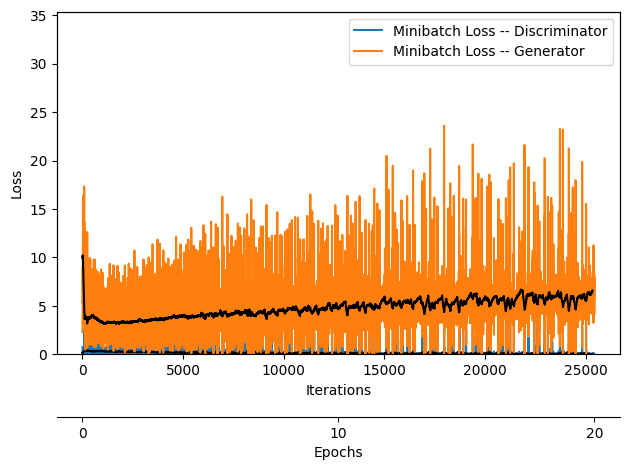

In [37]:
plot_multiple_training_losses(
    losses_list=(log_dict['train_discriminator_loss_per_batch'],
                 log_dict['train_generator_loss_per_batch']),
    num_epochs=NUM_EPOCHS, 
    custom_labels_list=(' -- Discriminator', ' -- Generator')
)